In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime as dt
pd.set_option("display.max_rows", 100)

## ALPHA VANTAGE KEY:  2S8Y5KX3WLVN7L5D

C:\Users\rafae\AppData\Roaming\Python\Python38\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [101]:
import requests

# Replace YOUR_API_KEY with your actual API key
api_key = '2S8Y5KX3WLVN7L5D'
endpoint = 'https://www.alphavantage.co/query'

# Specify the function and parameters for the request
params = {'function': 'LISTING_STATUS', 'apikey': api_key, 'state':'active'}

# Send the GET request to the API
response = requests.get(endpoint, params=params)

# Print the response from the API
print(response)


<Response [200]>


In [ ]:
print(response.content)

In [2]:
def get_clean_data(stock_list, start, end): # Download and clean data from yahoo finance
    data = yf.Tickers(stock_list)
    data = data.history(start=start, end=end)['Close']
    data.ffill(axis=0, inplace=True)
    
    for i, j in enumerate(data):
        if (data[j].isnull().values.any()):
            data.drop(j, inplace=True)
            return data

    return data

In [5]:
end = dt.datetime(2022,1,1)
start = dt.datetime(2015,1,1)

stocks = ['GOOG','QSAQAA', 'ASN=F', 'PETR4.SA']

df = get_clean_data(stocks, start, end)
df

[*********************100%***********************]  4 of 4 completed

1 Failed download:
- QSAQAA: No data found, symbol may be delisted


KeyError: "['QSAQAA'] not found in axis"

In [84]:
returns = df.pct_change()
cov_matrix = returns.cov()
mean_daily_returns = returns.mean()

num_portfolios = 10000

In [85]:
# Need +3 columns to sharpe, expected returns and volatility 
results = np.zeros((len(stocks) + 3, num_portfolios)) 

def efficient_frontier(cov_matrix, mean_daily_returns, num_portfolios, risk_free_rate=0):
    for i in range(num_portfolios):
        weights = np.array(np.random.random(len(cov_matrix)))  # Create a array with random weights from 0.0 to 1.0
        weights /= np.sum(weights)  # Divide by the sum of weights to make sum of array equals to 1.0

        portfolio_return = np.sum(mean_daily_returns *  weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) # Annualized std deviation (volatility)
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = (results[0, i] - risk_free_rate)/ results[1, i] # Sharpe ratio formula
        
        for j in range(len(weights)):
            results[j+3, i] = weights[j]
                   

efficient_frontier(cov_matrix, mean_daily_returns, num_portfolios, 0.05)


col_names = ["Return", "Volatility", "Sharpe"] + stocks.copy()
results_df = pd.DataFrame(results.T)
results_df.columns = [name for name in col_names]

          
max_sharpe = results_df.iloc[results_df['Sharpe'].idxmax()]  # Return the row of max_sharpe ratio
min_volatility = results_df.iloc[results_df['Volatility'].idxmin()]  # Return the row with minimum volatility 
print('-'*70)
print(f"Portfolio with max sharpe ratio in {num_portfolios} simulations\n{max_sharpe}")
print('-'*70)
print(f"Portfolio with min volatility in {num_portfolios} simulations\n{min_volatility}")   


----------------------------------------------------------------------
Portfolio with max sharpe ratio in 10000 simulations
Return        0.298756
Volatility    0.317570
Sharpe        0.783312
GOOG          0.002189
NVDA          0.530970
ASN=F         0.333304
PETR4.SA      0.133537
Name: 8089, dtype: float64
----------------------------------------------------------------------
Portfolio with min volatility in 10000 simulations
Return        0.092468
Volatility    0.181313
Sharpe        0.234225
GOOG          0.844588
NVDA          0.116315
ASN=F         0.021137
PETR4.SA      0.017959
Name: 7627, dtype: float64


In [16]:
def max_sharpe_and_min_vol(results_df):
    return (pd.DataFrame(results_df.iloc[results_df['Sharpe'].idxmax()])
            ,pd.DataFrame(results_df.iloc[results_df['Volatility'].idxmin()]))

In [12]:
import plotly
import plotly.express as px
import plotly.graph_objs as go
import json

In [87]:
def plotly_graph(results_df):
    max_sharpe, min_volatility = max_sharpe_and_min_vol(results_df)
# create a trace 
    data =[go.Scattergl(
        x = results_df.Volatility,
        y = results_df.Return,
        mode = 'markers',
        marker = dict(
            color = np.random.randn(len(results_df)),
            colorscale='magma'
        )
    ),
                   
        go.Scattergl(
            x = max_sharpe.iloc[1].values,
            y = max_sharpe.iloc[0].values,
            mode = 'markers',
            marker_symbol = 'star-dot',
            marker = dict(size=20),
            name = 'max_sharpe'
            ),
        
        go.Scattergl(
            x = min_volatility.iloc[1].values,
            y = min_volatility.iloc[0].values,
            mode = 'markers',
            marker_symbol = 'star-dot',
            marker = dict(size=20),
            name = 'min_volatility'
            )]

    layout = go.Layout(
            xaxis = dict(
                title = 'Volatility',
            ), 
            yaxis = dict(
                title = 'Return'
            ),
            width = 900,
            height = 600
    )

    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(title='Efficient Frontier')
    graphJSON = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

    # plotly.offline.plot(fig,filename='result.html')

    fig.show()
    return graphJSON
    
graph_JSON = plotly_graph(results_df)


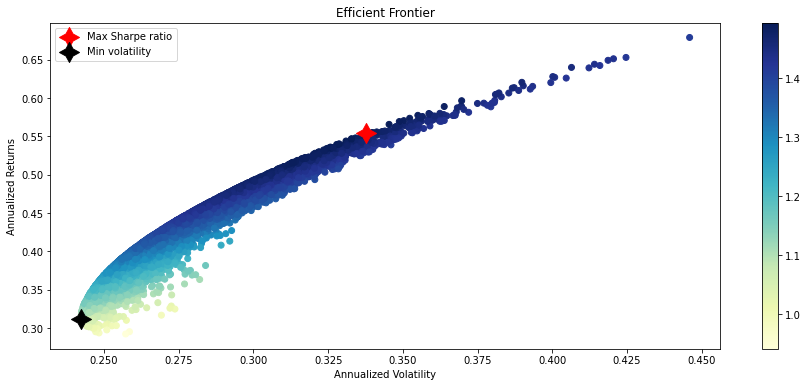

In [8]:

#plotting the efficient frontier
plt.figure(figsize=(15, 6))
plt.scatter(results_df.Volatility, results_df.Return, c=results_df.Sharpe, cmap='YlGnBu')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.title("Efficient Frontier")
plt.colorbar()


#plot a mark on the highest sharp ratio
plt.scatter(max_sharpe[1],max_sharpe[0], marker = (4,1,0), color='red', s=400, label='Max Sharpe ratio')
#plot a mark on the lowest std deviation portfolio
plt.scatter(min_volatility[1],min_volatility[0], marker = (4,1,0), color='black', s=400, label='Min volatility')
plt.legend()
plt.show()

